In [1]:
import os.path as op
import numpy as np
from scipy import stats as stats
from scipy.stats import pearsonr

import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_compare_evokeds

import mne
import matplotlib.pyplot as plt
from mne.minimum_norm import make_inverse_operator, apply_inverse, source_band_induced_power, apply_inverse_epochs,compute_source_psd, compute_source_psd_epochs
from mne.datasets import fetch_fsaverage

from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc


In [2]:
pain_rating = {'PASP001':5,'PASP002':6,'PASP003':6,'PASP004':6,'PASP005':8,
               'PASP007':5,'PASP008':5,'PASP010':0,'PASP012':3.5, 'PASP013':4,
               'PASP014':5,'PASP015':3,
               'PASP016':7,'PASP017':3,'PASP020':2.5,
               'PASP021': 7,'PASP022':4,'PASP023':4.5,'PASP025':8, 
               'PASP026':5.5, 'PASP027':5,'PASP028':3,'PASP029':6, 'PASP030':7, 'PASP031':5.5,'PASP032':7,'PASP033': 4.5
               }
len(pain_rating)
  
#'PASP009':6.5,'PASP011':7,'PASP019':7.5,


27

In [3]:
Control_list = ["PASC001", "PASC004", "PASC009", "PASC012", "PASC013", "PASC015", 
                "PASC020", "PASC022", "PASC025", "PASC030", "PASC037", "PASC040", 
                "PASC003", "PASC010", "PASC018", "PASC023", "PASC027", "PASC038", 
                "PASC005", "PASC011", "PASC014", "PASC019", "PASC024", "PASC034", 
                "PASC035", "PASC039", "PASC029", "PASC033", "PASC028", "PASC032",
                "PASC036", "PASC007", "PASC041"]

Patient_list = ["PASP001", 'PASP002',"PASP003", "PASP004", 'PASP005', "PASP007",  
                "PASP008",'PASP010', 'PASP012', "PASP013", 'PASP014','PASP015', 'PASP016', 
                "PASP017", 'PASP020', 'PASP021',"PASP022", 'PASP023', 'PASP025', 
                'PASP026', 'PASP027', 'PASP028', 'PASP029', 'PASP030', 'PASP031',
                "PASP032",'PASP033', "PASP006", 'PASP018']
#"PASP009", "PASP011", "PASP019",
len(Patient_list)

29

In [1]:
pain_rating = {'PASP001':5,'PASP002':6,'PASP003':6,'PASP004':6,'PASP005':8,'PASP007':5,'PASP008':5,
               'PASP013':4,'PASP015':3,'PASP016':7,'PASP017':3,'PASP022':4,'PASP023':4.5,'PASP025':8, 
               'PASP026':5.5, 'PASP027':5,'PASP028':3,'PASP029':6, 'PASP030':7, 'PASP031':5.5,'PASP032':7}

#'PASP009':6.5,'PASP011':7,
#'PASP025':8,'PASP026':5.5,'PASP027':5

Control_list = ["PASC001", "PASC004", "PASC009", "PASC012", "PASC013", "PASC015", 
                "PASC020", "PASC022", "PASC025", "PASC030", "PASC037", "PASC040", 
                "PASC003", "PASC010", "PASC018", "PASC023", "PASC027", "PASC038", 
                "PASC005", "PASC011", "PASC014", "PASC019", "PASC024", "PASC034", 
                "PASC035", "PASC039", "PASC029", "PASC033", "PASC028", "PASC032",
                "PASC036", "PASC007", "PASC041"]

Patient_list = ["PASP001", 'PASP002',"PASP003", "PASP004", 'PASP005', "PASP007",  
                "PASP008", "PASP013", "PASP015",'PASP016', "PASP017", "PASP022", 
                'PASP025', 'PASP026', 'PASP027', 'PASP028','PASP029', 'PASP030',
                'PASP023',"PASP031", "PASP032",'PASP018', "PASP006"]
                #"PASP009", "PASP011", ]
len(pain_rating)

21

In [5]:
fl, fh = 7.8,12

control_stcs = []
control_PAF =[]
patient_PAF=[]
control_max = []

Control_psds = []
Patient_psds = []
sum_psd_control = 0
sum_psd_patient = 0

Patient_psds_avg=[]
Control_psds_avg=[]

limits= (fl, fh)
for sub in Control_list[0:len(Patient_list)]:

    subjects_dir = "E:/Freesurfer_Files"

    psd_dir = "E:/Control_Sensor_PSDs/"
    fname= psd_dir+sub+"_SPONT_2_psd_MEG_sensor-ave.fif"
    
    psd = mne.read_evokeds(fname)[0]
    psd.pick(['eeg'])

    topo_norm = psd.data.sum(axis=1, keepdims=True)
    data_all = psd.copy().crop(*limits).data
    data_all = data_all/topo_norm
    control_PAF.append(psd.copy().crop(*limits).times[data_all.argmax()%29])
    
    data = psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)
    topos = mne.EvokedArray(data / topo_norm, psd.info)
    sum_psd_control += topos.data
    
    Control_psds_avg.append(topos.data)
    Control_psds.append(data_all)
    
sum_topo_control = mne.EvokedArray(sum_psd_control/len(Patient_list), psd.info)
sum_topo_control1 = mne.EvokedArray(np.array(Control_psds).mean(axis =0), psd.info, tmin=fl)

    
for sub in Patient_list:

    subjects_dir = "E:/Freesurfer_Files"
    psd_dir = "E:/Patient_Sensor_PSDs/"
    fname= psd_dir+sub+"_SPONT_2_psd_MEG_sensor-ave.fif"
    
    psd = mne.read_evokeds(fname)[0]
    psd.pick(['eeg'])
    topo_norm = psd.data.sum(axis=1, keepdims=True)
    
    data_all = psd.copy().crop(*limits).data
    data_all = data_all/topo_norm
    patient_PAF.append(psd.copy().crop(*limits).times[data_all.argmax()%29])

    data = psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)
    topos = mne.EvokedArray(data / topo_norm, psd.info)
    sum_psd_patient += topos.data
    
    Patient_psds_avg.append(topos.data)
    Patient_psds.append(data_all)
    
sum_topo_patient = mne.EvokedArray(sum_psd_patient/len(Patient_list), psd.info)
sum_topo_patient1 = mne.EvokedArray(np.array(Patient_psds).mean(axis =0), psd.info, tmin=fl)


Reading E:\Control_Sensor_PSDs\PASC001_SPONT_2_psd_MEG_sensor-ave.fif ...
    Found the data of interest:
        t =    4119.87 ...   79956.06 ms (Epoch 53 PSD)
        0 CTF compensation matrices available
        nave = 54 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied


ValueError: picks (['eeg']) could not be interpreted as channel names (no channel "['eeg']"), channel types (no type "['eeg']" present), or a generic type (just "all" or "data")

PearsonRResult(statistic=0.34180013819611343, pvalue=0.08098501022609263)


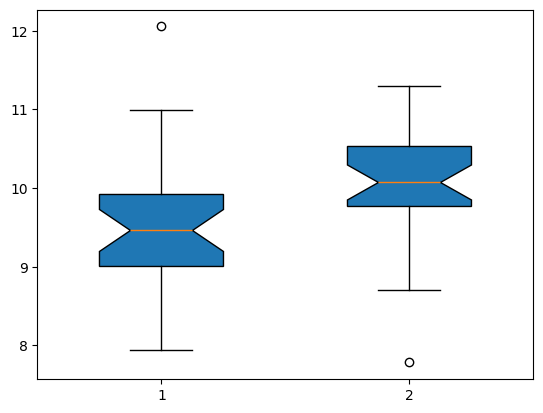

In [6]:
plt.boxplot([patient_PAF,control_PAF],patch_artist = True,widths =0.5,
                notch ='False')
print(pearsonr(patient_PAF[:-2],list(pain_rating.values())))

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


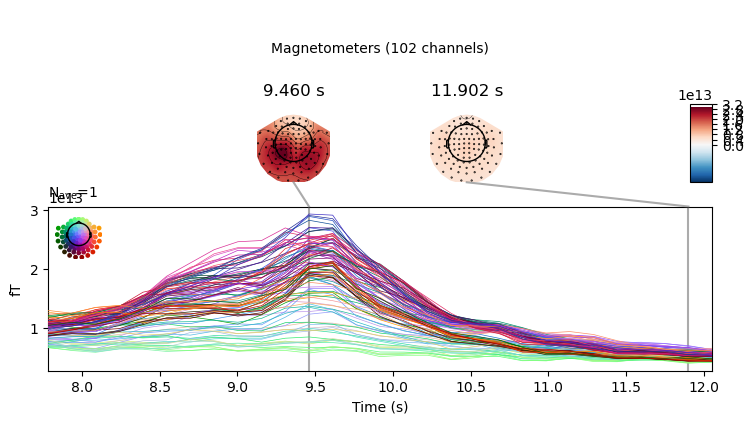

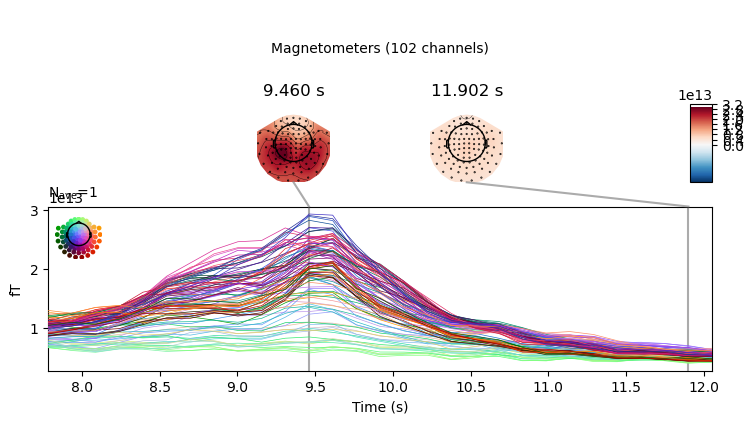

In [581]:
sum_topo_patient1.plot_joint(times='peaks')

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


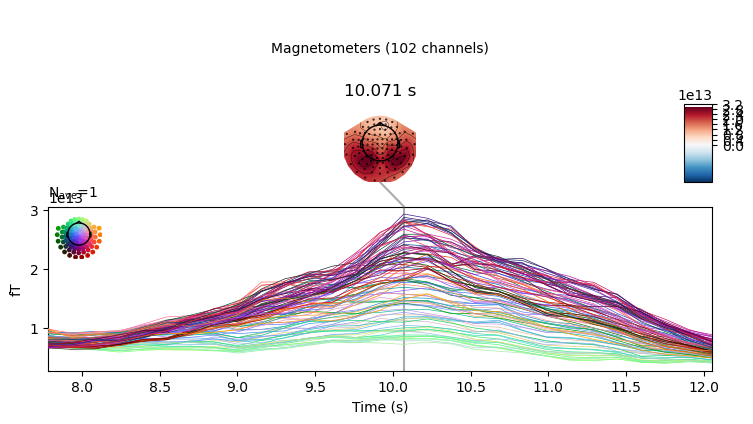

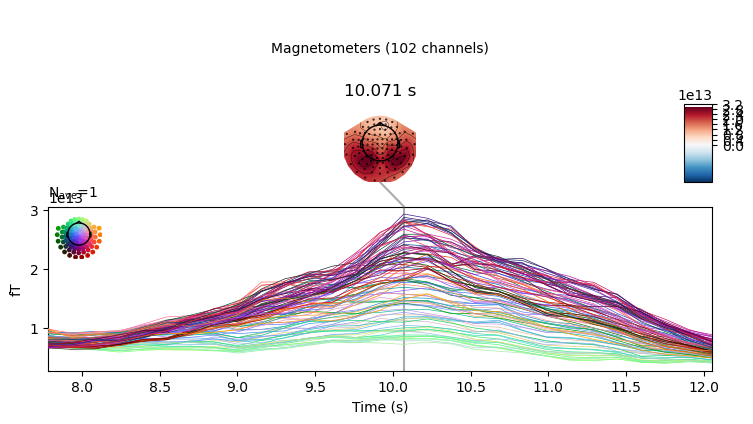

In [582]:
sum_topo_control1.plot_joint(times='peaks')

Text(0.5, -5.555555555555555, 'Normalized Alpha Power (8-12 Hz)')

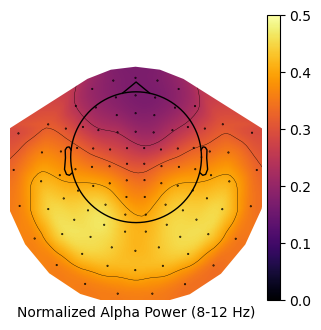

In [521]:
    # initialize figure
fig, ax_topo = plt.subplots(1, 1, figsize=(12, 3))

    # plot average test statistic and mark significant sensors
sum_topo_control.plot_topomap(
        times=0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(0, 0.5),
        axes=ax_topo,
        cmap="inferno",
        show=False,
        colorbar=False,
    )

image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
ax_topo.set_title("")
    # create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
        "Normalized Alpha Power (8-12 Hz)"
)


Text(0.5, -5.555555555555555, 'Normalized Alpha Power (8-12 Hz)')

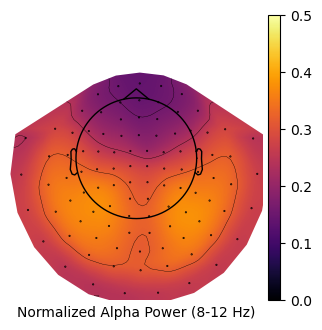

In [523]:
    # initialize figure
fig, ax_topo = plt.subplots(1, 1, figsize=(12, 3))

    # plot average test statistic and mark significant sensors
sum_topo_patient.plot_topomap(
        times=0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(0, 0.5),
        axes=ax_topo,
        cmap="inferno",
        show=False,
        colorbar=False,
    )
image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
ax_topo.set_title("")
    # create additional axes (for ERF and colorbar)
divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(image, cax=ax_colorbar)
ax_topo.set_xlabel(
        "Normalized Alpha Power (8-12 Hz)"
)



In [528]:
C1 = np.array(Control_psds)
C1 = np.reshape(C1,[C1.shape[0],C1.shape[2],C1.shape[1]])

C2 = np.array(Patient_psds)
C2 = np.reshape(C2,[C2.shape[0],C2.shape[2],C2.shape[1]])

C1 = np.abs(C1)  # only magnitude
C2 = np.abs(C2)
X=[C1,C2]

n_subjects1=n_subjects2=16
n_permutations = 10000
p_threshold = 0.001
f_threshold = stats.distributions.f.ppf(
    1.0 - p_threshold / 2.0, n_subjects1 - 1, n_subjects2 - 1
)
print("Clustering.")

F_obs, clusters, p_values, _ = cluster_stats = clu = spatio_temporal_cluster_test(
    X,
    adjacency=None,
    n_jobs=None,
    n_permutations=n_permutations,
    threshold=f_threshold,
    buffer_size=None,
)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(p_values < 0.05)[0]


Clustering.
stat_fun(H1): min=0.000000 max=22.618429
Running initial clustering …
Found 22 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [529]:
good_cluster_inds

array([ 0, 11, 12, 14], dtype=int64)

combining channels using "gfp"
combining channels using "gfp"


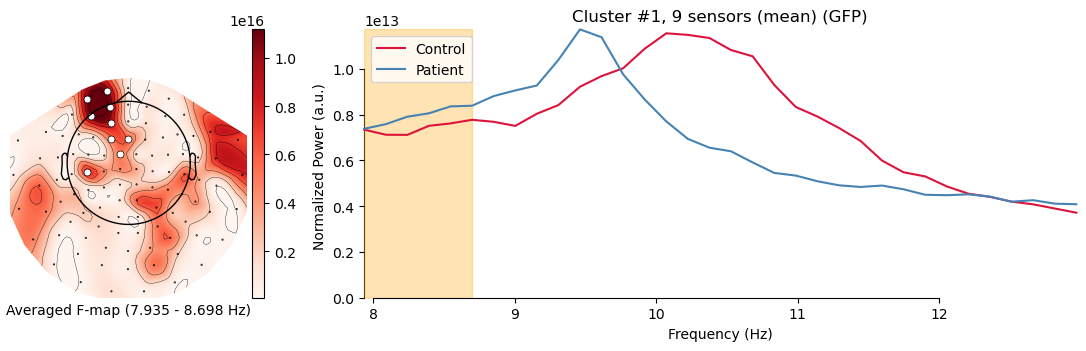

combining channels using "gfp"
combining channels using "gfp"


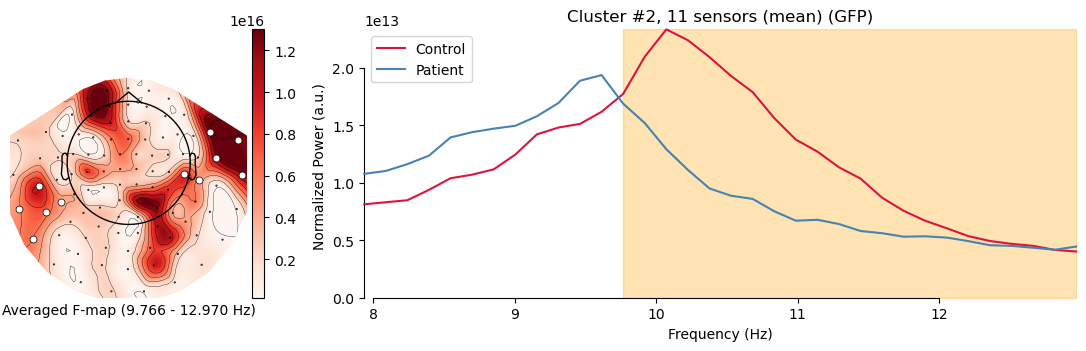

combining channels using "gfp"
combining channels using "gfp"


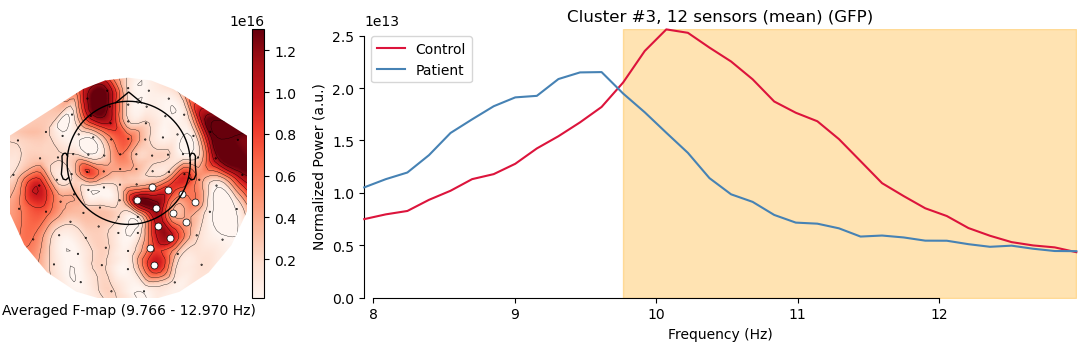

combining channels using "gfp"
combining channels using "gfp"


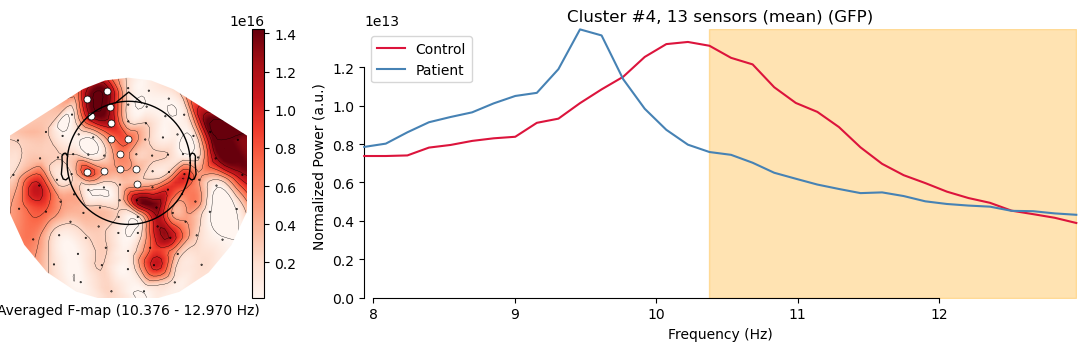

In [531]:
evokeds = {'Control': sum_topo_control1, 'Patient':sum_topo_patient1}

colors = {"Control": "crimson", "Patient": "steelblue"}
#linestyles = {"Control": "-", "Patient": "--"}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = F_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = sum_topo_control1.times[time_inds]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(12, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], sum_topo_control1.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} Hz)".format(*sig_times[[0, -1]])
    )

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1)
    title = "Cluster #{0}, {1} sensor".format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        axes=ax_signals,
        colors=colors,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )
    ax_signals.set_xlabel(
        "Frequency (Hz)".format(*sig_times[[0, -1]])
    )
    ax_signals.set_ylabel(
        "Normalized Power (a.u.) ".format(*sig_times[[0, -1]])
    )
    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=0.05)
    plt.show()

[267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282]


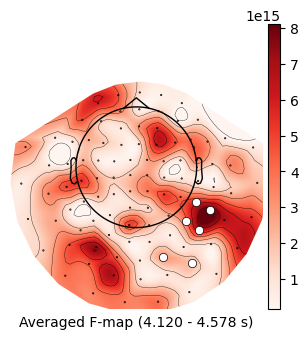

In [326]:
evokeds = {'Control': sum_topo_control1, 'Patient':sum_topo_patient1}

colors = {"Control": "crimson", "Patient": "steelblue"}

for i_clu, clu_idx in enumerate(good_cluster_inds[0:1]):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = F_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = psd.times[time_inds]
    
    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True
    print(ch_inds)
    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], psd.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=12),
    )
    image = ax_topo.images[0]
    ax_topo.set_title("")
    divider = make_axes_locatable(ax_topo)
   
    
    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )



In [324]:
len(mask1)

306

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


AttributeError: 'numpy.ndarray' object has no attribute 'get_ylim'

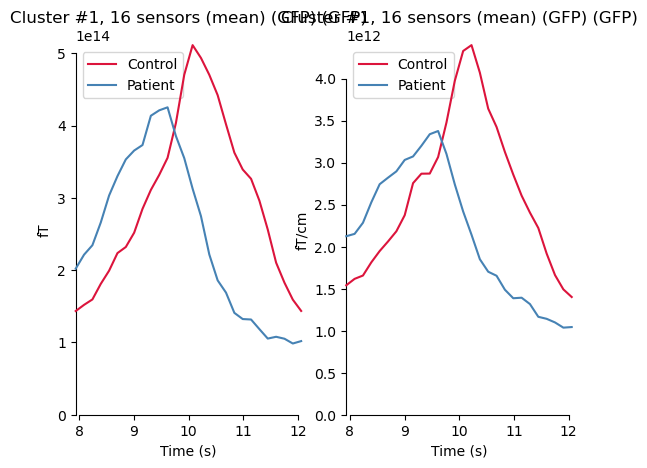

In [334]:
for i_clu, clu_idx in enumerate(good_cluster_inds[0:1]):

# add new axis for time courses and plot time courses
    _,ax_signals = plt.subplots(1,2)
    title = "Cluster #{0}, {1} sensor".format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
        
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        colors=colors,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
        axes=ax_signals
    )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=0.05)
    plt.show()

Multiple channel types selected, returning one figure per type.
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 1 Axes>, <Figure size 800x600 with 1 Axes>]

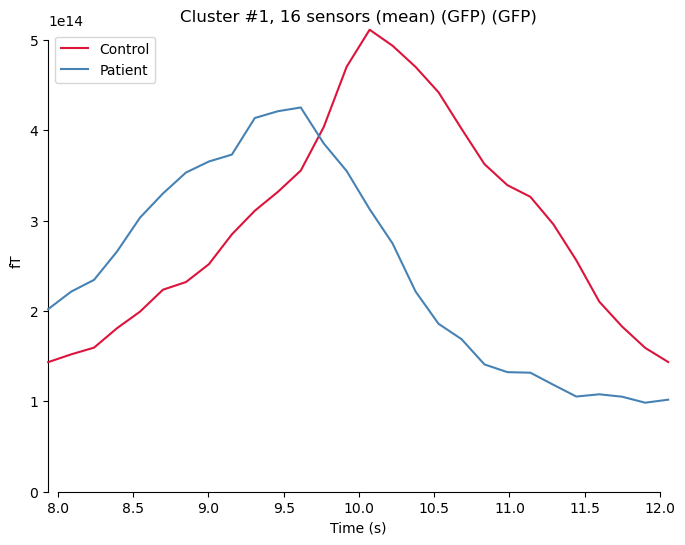

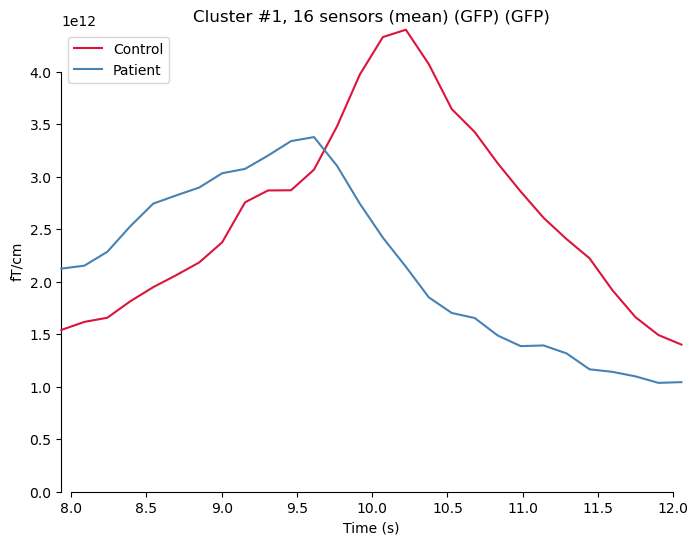

In [287]:
plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        colors=colors,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

In [240]:
good_clusters = np.where(cluster_p_values < 0.05)[0]


In [241]:
good_cluster_inds

array([79, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93], dtype=int64)

In [222]:
evoked_power_contrast = C1.mean(axis=0) - C2.mean(axis=0)
signs = np.sign(evoked_power_contrast)
# Create new stats image with only significant clusters

# Create new stats image with only significant clusters
F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        print(c)
        F_obs_plot[c] = F_obs[c] * signs[c]

(array([12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17,
       17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19,
       19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26,
       26, 26, 27, 27, 27, 27, 27, 27, 27, 27], dtype=int64), array([40, 41, 41, 42, 44, 42, 43, 44, 45, 46, 47, 48, 45, 46, 47, 48, 49,
       50, 51, 53, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 49, 50, 51, 52,
       53, 54, 55, 57, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 52, 53, 54,
       55, 56, 57, 58, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       61, 62, 63, 64, 65, 66, 67, 68

In [216]:
F_obs_plot.plot_topomap(times=0.0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(0, None),
        cmap="inferno")

AttributeError: 'numpy.ndarray' object has no attribute 'plot_topomap'

In [72]:
signs.shape

(19, 28, 306)

NameError: name 'ch_name' is not defined

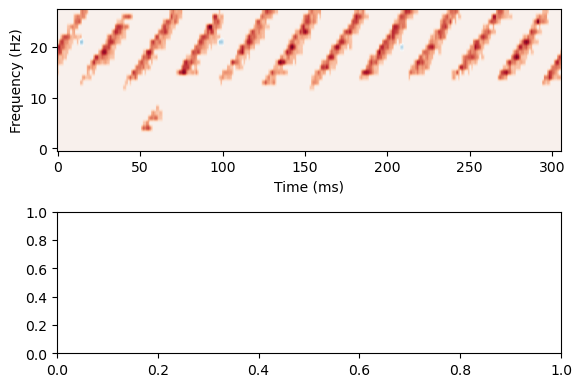

In [136]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
fig.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax.imshow(
    F_obs,
    aspect="auto",
    origin="lower",
    cmap="gray",
)
max_F = np.nanmax(abs(F_obs_plot))
ax.imshow(
    F_obs_plot,
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
    vmin=-max_F,
    vmax=max_F,
)

ax.set_xlabel("Time (ms)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title(f"Induced power ({ch_name})")


In [258]:
condition1 = np.array(Control_psds)
condition2 = np.array(Patient_psds)
condition1 = np.rollaxis(condition1,0,3)
condition2 = np.rollaxis(condition2,0,3)

n_vertices_sample, n_times, n_subjects = condition1.shape

# Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X = np.random.randn(n_vertices_sample, n_times, n_subjects, 2) * 10

X[:, :, :, 0] += condition1
X[:, :, :, 1] += condition2

X = np.abs(X)  # only magnitude
X = X[:, :, :, 0] - X[:, :, :, 1]  # make paired contrast

X = np.transpose(X, [2, 1, 0])


In [272]:
T, pval = scipy.stats.ttest_1samp(X, 0)
alpha = 0.05
reject_fdr, pval_fdr = mne.stats.fdr_correction(pval, alpha=alpha, method="indep")


In [ ]:
threshold_fdr = np.min(np.abs(T)[reject_fdr])

In [222]:
ch_adjacency,ch_names = mne.channels.find_ch_adjacency(psd.info, 'mag')

import scipy

n_observations=X1.shape[0]
pval = 0.001  # arbitrary

pval = 0.001  # arbitrary
df = n_observations - 1  # degrees of freedom for the test
thresh = scipy.stats.t.ppf(1 - pval / 2, df)  # two-tailed, t distribution

n_permutations = 10000

t_obs, clusters, cluster_p_values, h0=mne.stats.permutation_cluster_1samp_test(X, threshold=thresh, 
                                   n_permutations=n_permutations, 
                                   tail=0, stat_fun=None, adjacency=None, 
                                   n_jobs=None, seed=None, max_step=1, 
                                   exclude=None, step_down_p=0, t_power=1, 
                                   out_type='indices', check_disjoint=False, 
                                   buffer_size=1000, verbose=None)


Reading adjacency matrix for neuromag306mag.
stat_fun(H1): min=-2.371050 max=3.249399
Running initial clustering …
Found 0 clusters


C:\Users\malann\AppData\Local\Temp\ipykernel_71000\2902626672.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, cluster_p_values, h0=mne.stats.permutation_cluster_1samp_test(X, threshold=thresh,


In [298]:
cluster_p_values

array([0.13, 0.64, 0.83, 0.54, 0.37, 0.89, 0.66, 0.16, 0.37, 0.06, 0.9 ,
       0.16, 0.89, 0.89, 0.76, 0.78, 0.37, 0.89, 0.81, 0.23, 0.75, 0.13,
       0.43, 0.35, 0.86, 0.27, 0.16, 0.27, 0.73, 0.24, 0.56, 0.17, 0.04,
       0.9 , 0.67, 0.54, 0.54, 0.49, 0.87, 0.44, 0.87, 0.42, 0.75, 0.44,
       0.67, 0.13, 0.1 , 0.83, 0.23, 0.48, 0.08, 0.83, 0.08, 0.07, 0.06,
       0.89, 0.88, 0.13, 0.19, 0.83, 0.73, 0.08, 0.54, 0.17, 0.23, 0.2 ,
       0.9 , 0.81, 0.22, 0.52, 0.54, 0.81, 0.67, 0.9 , 0.4 , 0.15, 0.9 ,
       0.16, 0.9 , 0.01, 0.01, 0.89, 0.61, 0.6 , 0.61, 0.01, 0.34, 0.01,
       0.01, 0.9 , 0.54, 0.6 , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.89, 0.9 , 0.48, 0.87, 0.9 , 0.9 , 0.88, 0.63, 0.88, 0.69, 0.88,
       0.83, 0.59, 0.89, 0.89, 0.9 , 0.73, 0.9 , 0.81])

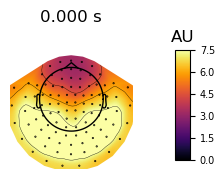

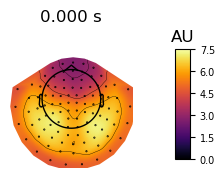

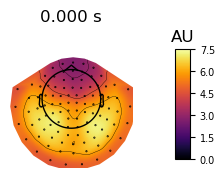

In [209]:
sum_topo_control.plot_topomap(
        times=0.0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(0, 7.5),
        cmap="inferno"
    )

sum_topo_patient.plot_topomap(
        times=0.0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(0, 7.5),
        cmap="inferno"
    )

In [210]:
good_clusters = np.where(cluster_p_values < 0.05)[0]
good_clusters

array([], dtype=int64)

In [211]:
t_obs.shape

(28, 306)

In [213]:
t_obs.mean(axis = 0).shape

(306,)

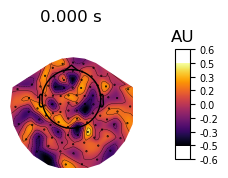

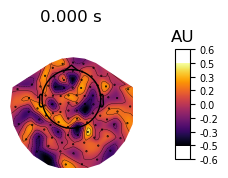

In [215]:
F_obs = mne.EvokedArray(t_obs.mean(axis = 0).reshape(t_obs.shape[1],1), psd.info)

F_obs.plot_topomap(
        times=0.0,
        scalings=1.0,
        cbar_fmt="%0.1f",
        vlim=(None, None),
        cmap="inferno"
    )

In [83]:
good_clusters = np.where(cluster_p_values < 0.05)[0]
F_obs_plot = F_obs.copy()


In [84]:
good_clusters

array([10, 13, 19, 29], dtype=int64)